In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle
import math
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score,KFold,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

import torch
import torch.nn as nn
from torch.autograd import Variable 

In [2]:
import seaborn as sns
def plot_scatter_avp(actuals, predictions):
        df = pd.DataFrame({"actual": actuals, "predicted": predictions})

        max_actual = max(df.actual)

        fig = sns.scatterplot(data=df, x="actual", y="predicted", s=3, marker="o")
        fig.plot(np.linspace(0, max_actual), np.linspace(0, max_actual), "-r")
        plt.show()

In [3]:
df = pd.read_csv('data_with_indicators_new.csv')

In [4]:
list_y = ['Period',
            'month',
            'quarter',
            'halfyear',
            'year']

<AxesSubplot:>

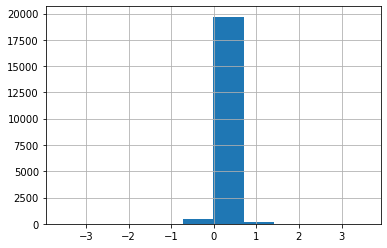

In [5]:
df[list_y[4]].hist()

In [6]:
def y_preprocessing(name, df):
    df = df[(df[name]>-0.2)&(df[name]<0.2)]
    df = df.dropna()
    dummy = pd.get_dummies(df['Ticker'])
    df = pd.merge(df, dummy, left_index=True, right_index=True, how='inner')
    df = df.drop('Ticker', axis=1)
    df['Date'] = pd.to_datetime(df['Date'])
    df['nb_months'] = ((df['Date'] - pd.to_datetime('2004-02'))/np.timedelta64(1, 'M'))
    df['nb_months'] = df['nb_months'].astype(int)
    df = df.drop('Date', axis=1)
    
    df = df.rename(columns={name: "Y"})
    for e in df.columns:
        if e in list_y:
            df = df.drop(e, axis=1)
    return df

In [7]:
list_dfs = []
for e in list_y:
    df_new = df.copy()
    df_2 = y_preprocessing(e, df_new)
    list_dfs.append(df_2)

In [8]:
# correlation_matrix = df.corr()

In [9]:
# correlation_matrix

## Predict

In [26]:
model_xgb = pickle.load(open('xgboost_final_model.sav', 'rb'))

In [27]:
def predict_data(df, model):
    y_test = df['Y']
    X = df.drop('Y', axis=1)
    y_pred = model.predict(X)
    
    rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print('Testing performance')
    print('RMSE: {:.2f}'.format(rmse))
    print('R2: {:.2f}'.format(r2))
    print('MAE: {:.2f}'.format(mae))

In [28]:
for data in list_dfs:
    predict_data(data, model_xgb)

Testing performance
RMSE: 0.02
R2: 0.90
MAE: 0.01
Testing performance
RMSE: 0.05
R2: 0.10
MAE: 0.03
Testing performance
RMSE: 0.05
R2: -0.80
MAE: 0.04
Testing performance
RMSE: 0.05
R2: -1.48
MAE: 0.04
Testing performance
RMSE: 0.05
R2: -3.03
MAE: 0.04


## XGBoost

In [30]:
def train_model(df, params_right):
    y = df['Y']
    X = df.drop("Y", axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=69)
    eval_set = [(X_train, y_train), (X_val, y_val)]

    model_xgb = XGBRegressor(**params_right)
    model_xgb.fit(X_train,
                  y_train,
                  verbose=0,
                  eval_set=eval_set,
                  eval_metric='rmse',
                  early_stopping_rounds=50
                  )

    y_pred = model_xgb.predict(X_test, ntree_limit=model_xgb.best_ntree_limit)
    y_pred_train = model_xgb.predict(X_train)

    rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print('Testing performance')
    print('RMSE: {:.2f}'.format(rmse))
    print('R2: {:.2f}'.format(r2))
    print('MAE: {:.2f}'.format(mae))

    return model_xgb, y_pred, y_pred_train, y_test, y_train

In [32]:
params_right = {'colsample_bytree': 1, 
                'eval_metric': 'rmse', 
                'gamma': 0, 
                'grow_policy': 'depthwise', 
                'learning_rate': 0.05, 
                'max_depth': 6, 
                'n_estimators': 300, 
                'reg_alpha': 0, 
                'reg_lambda': 0, 
                'subsample': 0.8}

d_final = {}
n = 0
for data in list_dfs:
    model_xgb, y_pred, y_pred_train, y_test, y_train = train_model(data, params_right)
    d_final[n] = [model_xgb, y_pred, y_pred_train, y_test, y_train]
    n +=1

c:\users\kkwas\pycharmprojects\pythonproject\venv\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Testing performance
RMSE: 0.02
R2: 0.81
MAE: 0.01


c:\users\kkwas\pycharmprojects\pythonproject\venv\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Testing performance
RMSE: 0.04
R2: 0.22
MAE: 0.03


c:\users\kkwas\pycharmprojects\pythonproject\venv\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Testing performance
RMSE: 0.04
R2: 0.07
MAE: 0.02


c:\users\kkwas\pycharmprojects\pythonproject\venv\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Testing performance
RMSE: 0.03
R2: 0.01
MAE: 0.02
Testing performance
RMSE: 0.03
R2: -0.01
MAE: 0.01


c:\users\kkwas\pycharmprojects\pythonproject\venv\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


## one dataframe model

In [17]:
y = df['Y']
X = df.drop("Y", axis=1)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=69)

In [19]:
params_CV_xgb_only = {'colsample_bytree': 1, 
                      'eval_metric': 'rmse', 
                      'gamma': 3, 
                      'grow_policy': 'depthwise', 
                      'learning_rate': 0.03, 
                      'max_depth': 8, 
                      'n_estimators': 500, 
                      'reg_alpha': 0, 
                      'reg_lambda': 3, 
                      'subsample': 0.8}

In [20]:
params_right = {'colsample_bytree': 1, 
                'eval_metric': 'rmse', 
                'gamma': 0, 
                'grow_policy': 'depthwise', 
                'learning_rate': 0.05, 
                'max_depth': 6, 
                'n_estimators': 300, 
                'reg_alpha': 0, 
                'reg_lambda': 0, 
                'subsample': 0.8}

In [21]:
eval_set = [(X_train, y_train), (X_val, y_val)]

model_xgb = XGBRegressor(**params_right)
model_xgb.fit(X_train,
              y_train,
              verbose=0,
              eval_set=eval_set,
              eval_metric='rmse',
              early_stopping_rounds=50
              )

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=16, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [22]:
y_pred = model_xgb.predict(X_test, ntree_limit=model_xgb.best_ntree_limit)

c:\users\kkwas\pycharmprojects\pythonproject\venv\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [26]:
y_pred_train = model_xgb.predict(X_train)

In [23]:
rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))
print('MAE: {:.2f}'.format(mae))

Testing performance
RMSE: 0.02
R2: 0.81
MAE: 0.01


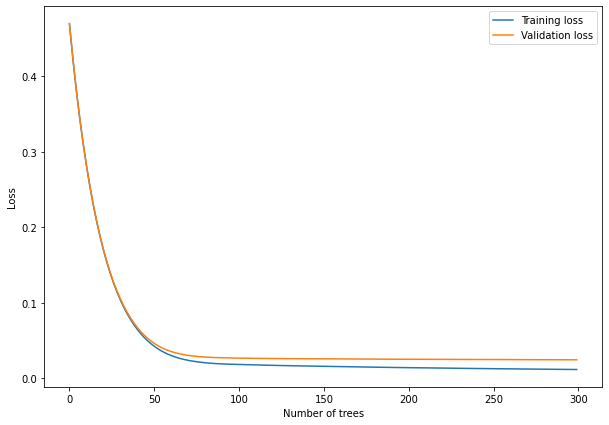

In [24]:
# plot error
results = model_xgb.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
# plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()
plt.show()

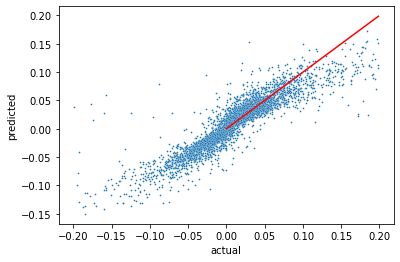

In [27]:
plot_scatter_avp(y_test, y_pred)

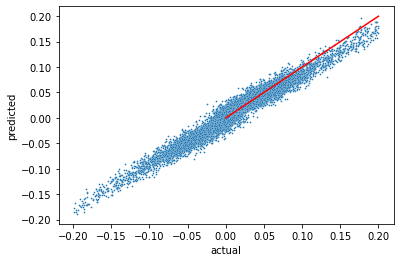

In [28]:
plot_scatter_avp(y_train, y_pred_train)

In [32]:
# save the model to disk
filename = 'xgboost_final_model.pickle'
pickle.dump(model_xgb, open(filename, 'wb'))

## Grid Search XGBoost

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

In [84]:
params_CV_xgb = {
    'n_estimators': [100, 300],
    'learning_rate': [0.05, 0.03],
    'max_depth': [4, 6],
    'eval_metric': ['rmse'],
    'colsample_bytree': [1],
    'subsample': [0.8],
    'reg_alpha': [0, 1],
    'grow_policy': ['depthwise'],
    'reg_lambda': [0, 3],
    'gamma':[0, 3]
}


In [90]:
model = XGBRegressor()
kf=KFold(n_splits=2)
model_cv = GridSearchCV(estimator = model, 
                        param_grid = params_CV_xgb, 
                        scoring= 'neg_root_mean_squared_error', 
                        cv = kf, 
                        verbose = 100,
                        return_train_score=True)  

In [89]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [91]:
x = model_cv.fit(X_train, y_train)
model = x.best_estimator_
print(x.best_params_)
pred = model.predict(X_test)

Fitting 2 folds for each of 64 candidates, totalling 128 fits
[CV 1/2; 1/64] START colsample_bytree=1, eval_metric=rmse, gamma=0, grow_policy=depthwise, learning_rate=0.05, max_depth=4, n_estimators=100, reg_alpha=0, reg_lambda=0, subsample=0.8
[CV 1/2; 1/64] END colsample_bytree=1, eval_metric=rmse, gamma=0, grow_policy=depthwise, learning_rate=0.05, max_depth=4, n_estimators=100, reg_alpha=0, reg_lambda=0, subsample=0.8;, score=(train=-0.025, test=-0.029) total time=   1.4s
[CV 2/2; 1/64] START colsample_bytree=1, eval_metric=rmse, gamma=0, grow_policy=depthwise, learning_rate=0.05, max_depth=4, n_estimators=100, reg_alpha=0, reg_lambda=0, subsample=0.8
[CV 2/2; 1/64] END colsample_bytree=1, eval_metric=rmse, gamma=0, grow_policy=depthwise, learning_rate=0.05, max_depth=4, n_estimators=100, reg_alpha=0, reg_lambda=0, subsample=0.8;, score=(train=-0.025, test=-0.028) total time=   1.4s
[CV 1/2; 2/64] START colsample_bytree=1, eval_metric=rmse, gamma=0, grow_policy=depthwise, learning_

In [92]:
y_pred = model_cv.predict(X_test)

In [98]:
y_pred_train = model_cv.predict(X_train)

In [93]:
rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))
print('MAE: {:.2f}'.format(mae))

Testing performance
RMSE: 0.02
R2: 0.82
MAE: 0.01


In [94]:
# {'colsample_bytree': 1, 'eval_metric': 'rmse', 'gamma': 0, 'grow_policy': 'depthwise', 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.8}

In [71]:
import seaborn as sns
def plot_scatter_avp(actuals, predictions):
        df = pd.DataFrame({"actual": actuals, "predicted": predictions})

        max_actual = max(df.actual)

        fig = sns.scatterplot(data=df, x="actual", y="predicted", s=3, marker="o")
        fig.plot(np.linspace(0, max_actual), np.linspace(0, max_actual), "-r")
        plt.show()

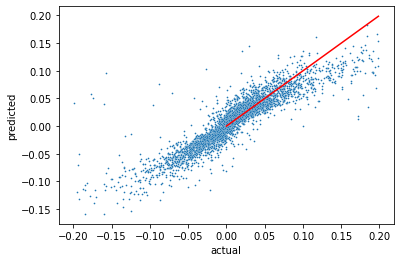

In [97]:
plot_scatter_avp(y_test, y_pred)

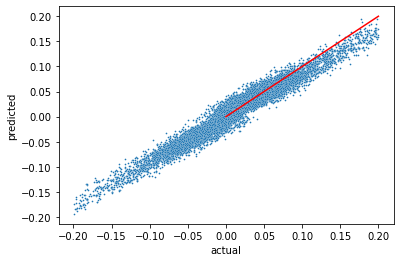

In [99]:
plot_scatter_avp(y_train, y_pred_train)

## LSTM/GRU 

In [13]:
def deep_modeling(df, input_dim, hidden_dim, output_dim, num_layers):
    y = df['Y']
    X = df.drop("Y", axis=1)
    X_dl = X.to_numpy()
    y_dl = y.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X_dl, y_dl, test_size=0.2, random_state=420)
    X_train_tensors = Variable(torch.Tensor(X_train))
    X_test_tensors = Variable(torch.Tensor(X_test))

    y_train_tensors = Variable(torch.Tensor(y_train))
    y_test_tensors = Variable(torch.Tensor(y_test))
    
    X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], X_train_tensors.shape[1], 1))
    X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], X_test_tensors.shape[1], 1))

    y_train_tensors_final = torch.reshape(y_train_tensors,   (y_train_tensors.shape[0], 1))
    y_test_tensors_final = torch.reshape(y_test_tensors,  (y_test_tensors.shape[0], 1))
    
    model = LSTM(input_dim=input_dim, 
             hidden_dim=hidden_dim, 
             output_dim=output_dim, 
             num_layers=num_layers)
    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
    
    hist = np.zeros(num_epochs)
    start_time = time.time()
    lstm = []
    for t in range(num_epochs):
        y_train_pred = model(X_train_tensors_final)
        loss = criterion(y_train_pred, y_train_tensors_final)
        print("Epoch ", t, "MSE: ", loss.item())
        hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    training_time = time.time()-start_time
    print("Training time: {}".format(training_time))
    
    # make predictions
    y_test_pred = model(X_test_tensors_final)
    y_test_pred.shape
    
    y_train_pred = y_train_pred.detach().numpy()
    y_train = y_train_tensors_final.detach().numpy()
    y_test_pred = y_test_pred.detach().numpy()
    y_test = y_test_tensors_final.detach().numpy()
    
    trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    lstm.append(trainScore)
    lstm.append(testScore)
    lstm.append(training_time)
    
    return lstm, y_pred, y_pred_train, y_test, y_train

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        # self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [15]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [16]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 50

In [18]:
d_final = {}
n = 0

lstm, y_pred, y_pred_train, y_test, y_train = deep_modeling(list_dfs[1], input_dim, hidden_dim, output_dim, num_layers)
d_final[n] = [lstm, y_pred, y_pred_train, y_test, y_train]

Epoch  0 MSE:  0.013651130720973015
Epoch  1 MSE:  0.015885669738054276
Epoch  2 MSE:  0.0069469003938138485
Epoch  3 MSE:  0.0027748295105993748
Epoch  4 MSE:  0.004286967217922211
Epoch  5 MSE:  0.005876431707292795
Epoch  6 MSE:  0.005736224818974733
Epoch  7 MSE:  0.00447099469602108
Epoch  8 MSE:  0.003145502181723714
Epoch  9 MSE:  0.0025206527207046747
Epoch  10 MSE:  0.002794441767036915
Epoch  11 MSE:  0.0034346103202551603
Epoch  12 MSE:  0.00367955700494349
Epoch  13 MSE:  0.0033655918668955564
Epoch  14 MSE:  0.002839749213308096
Epoch  15 MSE:  0.00248534488491714
Epoch  16 MSE:  0.0024336394853889942
Epoch  17 MSE:  0.002575287828221917
Epoch  18 MSE:  0.002752161119133234
Epoch  19 MSE:  0.002851156983524561
Epoch  20 MSE:  0.0028300960548222065
Epoch  21 MSE:  0.002711272332817316
Epoch  22 MSE:  0.0025560574140399694
Epoch  23 MSE:  0.0024326087441295385
Epoch  24 MSE:  0.002385849831625819
Epoch  25 MSE:  0.002418695017695427
Epoch  26 MSE:  0.002493290463462472
Epoch

NameError: name 'y_pred' is not defined

## One dataset modeling

In [51]:
X_dl = X.to_numpy()
y_dl = y.to_numpy()

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_dl, y_dl, test_size=0.2, random_state=420)

In [53]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

In [58]:
y_train_tensors.shape

torch.Size([15272])

In [57]:
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], X_train_tensors.shape[1], 1))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], X_test_tensors.shape[1], 1))

y_train_tensors_final = torch.reshape(y_train_tensors,   (y_train_tensors.shape[0], 1))
y_test_tensors_final = torch.reshape(y_test_tensors,  (y_test_tensors.shape[0], 1)) 

In [59]:
y_test_tensors_final.shape

torch.Size([3819, 1])

In [60]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 50

In [64]:
model = LSTM(input_dim=input_dim, 
             hidden_dim=hidden_dim, 
             output_dim=output_dim, 
             num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [66]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(X_train_tensors_final)
    loss = criterion(y_train_pred, y_train_tensors_final)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.0054879700765013695
Epoch  1 MSE:  0.005546393804252148
Epoch  2 MSE:  0.011457887478172779
Epoch  3 MSE:  0.011637087911367416
Epoch  4 MSE:  0.008776838891208172
Epoch  5 MSE:  0.005671583116054535
Epoch  6 MSE:  0.0035988297313451767
Epoch  7 MSE:  0.002927315654233098
Epoch  8 MSE:  0.003432739991694689
Epoch  9 MSE:  0.0041704862378537655
Epoch  10 MSE:  0.004393030423671007
Epoch  11 MSE:  0.004092009272426367
Epoch  12 MSE:  0.003578804899007082
Epoch  13 MSE:  0.003142380388453603
Epoch  14 MSE:  0.002925268141552806
Epoch  15 MSE:  0.0029268504586070776
Epoch  16 MSE:  0.003063506679609418
Epoch  17 MSE:  0.0032308262307196856
Epoch  18 MSE:  0.0033466529566794634
Epoch  19 MSE:  0.003371268277987838
Epoch  20 MSE:  0.003307400504127145
Epoch  21 MSE:  0.0031874263659119606
Epoch  22 MSE:  0.003055957145988941
Epoch  23 MSE:  0.002953531453385949
Epoch  24 MSE:  0.002904675668105483
Epoch  25 MSE:  0.002912231022492051
Epoch  26 MSE:  0.0029589501209557056
Epo

In [72]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(X_test_tensors_final)
y_test_pred.shape

torch.Size([3819, 1])

In [68]:
torch.save(model.state_dict(), 'model_LSTM.pt')

In [73]:
# invert predictions
# y_train_pred = y_train_pred.detach().numpy()
y_train = y_train_tensors_final.detach().numpy()
y_test_pred = y_test_pred.detach().numpy()
y_test = y_test_tensors_final.detach().numpy()

In [74]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 0.05 RMSE
Test Score: 0.05 RMSE


In [75]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_dl, y_dl, test_size=0.2, random_state=420)

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], X_train_tensors.shape[1], 1))

X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], X_test_tensors.shape[1], 1))

y_train_tensors_final = torch.reshape(y_train_tensors,   (y_train_tensors.shape[0], 1))
y_test_tensors_final = torch.reshape(y_test_tensors,  (y_test_tensors.shape[0], 1)) 

In [77]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(X_train_tensors_final)
    loss = criterion(y_train_pred, y_train_tensors_final)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.05450622737407684
Epoch  1 MSE:  0.03689612075686455
Epoch  2 MSE:  0.031600143760442734
Epoch  3 MSE:  0.0071031441912055016
Epoch  4 MSE:  0.004293963313102722
Epoch  5 MSE:  0.011633778922259808
Epoch  6 MSE:  0.013792445883154869
Epoch  7 MSE:  0.009346707724034786
Epoch  8 MSE:  0.004175536800175905
Epoch  9 MSE:  0.0031369670759886503
Epoch  10 MSE:  0.004360849037766457
Epoch  11 MSE:  0.0051625799387693405
Epoch  12 MSE:  0.004727320279926062
Epoch  13 MSE:  0.003703546477481723
Epoch  14 MSE:  0.0030248600523918867
Epoch  15 MSE:  0.002967854030430317
Epoch  16 MSE:  0.0032879039645195007
Epoch  17 MSE:  0.0036011599004268646
Epoch  18 MSE:  0.003631589002907276
Epoch  19 MSE:  0.003363940631970763
Epoch  20 MSE:  0.003033748595044017
Epoch  21 MSE:  0.002925993176177144
Epoch  22 MSE:  0.0030210709664970636
Epoch  23 MSE:  0.0031631519086658955
Epoch  24 MSE:  0.0032337636221200228
Epoch  25 MSE:  0.003190661082044244
Epoch  26 MSE:  0.003074696520343423
Epoc

In [78]:
y_test_pred = model(X_test_tensors_final)
y_test_pred.shape

torch.Size([3819, 1])

In [79]:
torch.save(model.state_dict(), 'model_GRU.pt')

In [80]:
y_train_pred = y_train_pred.detach().numpy()
y_train = y_train_tensors_final.detach().numpy()
y_test_pred = y_test_pred.detach().numpy()
y_test = y_test_tensors_final.detach().numpy()

In [81]:
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 0.05 RMSE
Test Score: 0.05 RMSE


## Random Forest

In [36]:
from sklearn.ensemble import RandomForestRegressor

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=420)

In [44]:
params_rf = {'bootstrap': True, 
             'max_depth': 8, 
             'max_samples': 0.75, 
             'min_samples_split': 2, 
             'n_estimators': 500}

In [45]:
rf = RandomForestRegressor(**params_rf)

In [46]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, max_samples=0.75, n_estimators=500)

In [48]:
pred = rf.predict(X_test)

In [49]:
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
mae = mean_absolute_error(y_test, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))
print('MAE: {:.2f}'.format(mae))

Testing performance
RMSE: 0.03
R2: 0.72
MAE: 0.02


In [50]:
filename = 'random_forest_final_model.sav'
pickle.dump(rf, open(filename, 'wb'))

## Grid for Random Forest

In [43]:
params_CV_rf = {
    'n_estimators': [100, 300, 500],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 4],
    'bootstrap': [True],
    'max_samples': [0.75, 1]
    
}

In [ ]:
rf = RandomForestRegressor()

In [66]:
kf=KFold(n_splits=3)
model_cv = GridSearchCV(estimator = rf, 
                        param_grid = params_CV_rf, 
                        scoring= 'neg_mean_squared_error', 
                        cv = kf, 
                        verbose = 100,
                        return_train_score=True)  

In [67]:
x = model_cv.fit(X_train, y_train)
model = x.best_estimator_
print(x.best_params_)
pred = model.predict(X_test)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3; 1/36] START bootstrap=True, max_depth=4, max_samples=0.75, min_samples_split=2, n_estimators=100
[CV 1/3; 1/36] END bootstrap=True, max_depth=4, max_samples=0.75, min_samples_split=2, n_estimators=100;, score=(train=-0.001, test=-0.001) total time=  16.7s
[CV 2/3; 1/36] START bootstrap=True, max_depth=4, max_samples=0.75, min_samples_split=2, n_estimators=100
[CV 2/3; 1/36] END bootstrap=True, max_depth=4, max_samples=0.75, min_samples_split=2, n_estimators=100;, score=(train=-0.001, test=-0.001) total time=  16.7s
[CV 3/3; 1/36] START bootstrap=True, max_depth=4, max_samples=0.75, min_samples_split=2, n_estimators=100
[CV 3/3; 1/36] END bootstrap=True, max_depth=4, max_samples=0.75, min_samples_split=2, n_estimators=100;, score=(train=-0.001, test=-0.001) total time=  16.6s
[CV 1/3; 2/36] START bootstrap=True, max_depth=4, max_samples=0.75, min_samples_split=2, n_estimators=300
[CV 1/3; 2/36] END bootstrap=True, ma

In [68]:
y_pred_train = model_cv.predict(X_train)

In [70]:
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
mae = mean_absolute_error(y_test, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))
print('MAE: {:.2f}'.format(mae))

Testing performance
RMSE: 0.03
R2: 0.72
MAE: 0.02


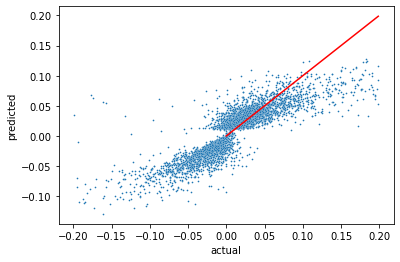

In [75]:
plot_scatter_avp(y_test, pred)

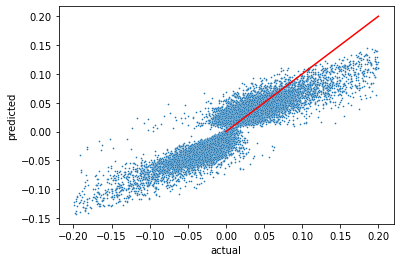

In [76]:
plot_scatter_avp(y_train, y_pred_train)

In [ ]:
# {'bootstrap': True, 'max_depth': 8, 'max_samples': 0.75, 'min_samples_split': 2, 'n_estimators': 500}